In [1]:
!pip install pandas scikit-learn matplotlib seaborn --quiet

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



ACES DATASET


In [15]:
from scipy.io import loadmat
import pandas as pd
import numpy as np

base_directory = '.'
X = pd.DataFrame(loadmat(f'/content/DATASET/ACESExpr.mat')['data'])
y = loadmat(f'/content/DATASET/ACESLabel.mat')['label'].reshape(-1)
subtypes = np.loadtxt(f'/content/DATASET/ACES_Subtype.txt').astype(int)
entrez_gene_id = loadmat(f'/content/DATASET/ACES_EntrezIds.mat')['entrez_ids']
X.columns = entrez_gene_id.reshape(-1)

**RF Simple**

In [16]:
  # Convert X (DataFrame) to 2D NumPy array
X_np = X.values.astype(float)  # Shape: (1616, 12750)

# Convert y (already 1D from reshape) to int type
y_np = y.astype(int)           # Shape: (1616,)

# Print shapes to verify
print("X shape:", X_np.shape)
print("y shape:", y_np.shape)

# Preview first 2 samples (rows) and first 5 genes (columns)
print("\nX sample (first 2 rows, first 5 genes):")
print(X_np[:2, :10])

# Preview first 10 labels
print("\ny sample (first 10 labels):")
print(y_np[:10])


X shape: (1616, 12750)
y shape: (1616,)

X sample (first 2 rows, first 5 genes):
[[ 0.10613358 -0.03385032  0.08024156 -0.45017619  0.53153049  0.39247084
   0.10864689 -0.19510369 -0.03583708 -0.16883119]
 [ 0.39469659  0.3944242  -0.14407069 -0.28516317  0.18738481  0.10154901
   0.35171932  0.51011809 -0.55127033  0.98131516]]

y sample (first 10 labels):
[1 0 0 0 0 0 0 0 0 0]


In [17]:
# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# Step 3: Define the Random Forest and hyperparameter grid
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# Step 4: Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

# Step 5: Fit the model
grid_search.fit(X_train, y_train)

# Step 6: Get the best model
best_rf = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}



Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84       233
           1       0.64      0.20      0.30        91

    accuracy                           0.74       324
   macro avg       0.70      0.58      0.57       324
weighted avg       0.72      0.74      0.69       324

Accuracy: 0.7438271604938271


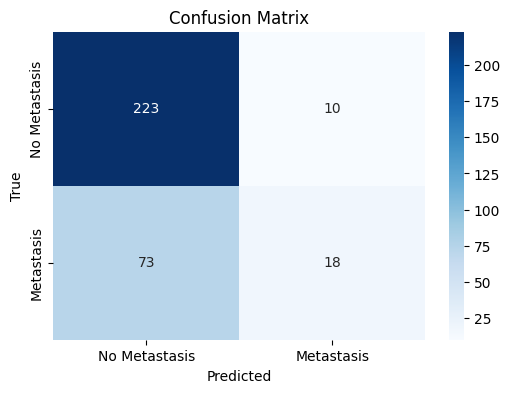

In [18]:
# Step 7: Evaluate on test set
y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 8: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Metastasis", "Metastasis"], yticklabels=["No Metastasis", "Metastasis"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**RF with SMOTE**

In [19]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 1: Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np,
    test_size=0.2,
    stratify=y_np,
    random_state=42
)

# Step 2: Oversample minority class
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Step 3: Train with class weighting (optional, you can skip it since SMOTE balances)
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_res, y_train_res)

y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
# Step 4: Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.90      0.83       233
           1       0.57      0.35      0.44        91

    accuracy                           0.74       324
   macro avg       0.68      0.62      0.63       324
weighted avg       0.72      0.74      0.72       324



**RF+Tomek Link**

In [20]:
!pip install imbalanced-learn --quiet

from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 1: Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

# Step 2: Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Step 3: Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
# Step 4: Evaluate
y_pred = model.predict(X_test)
print("SMOTE + Tomek Links")
print(classification_report(y_test, y_pred))


SMOTE + Tomek Links
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       233
           1       0.55      0.32      0.40        91

    accuracy                           0.73       324
   macro avg       0.66      0.61      0.62       324
weighted avg       0.71      0.73      0.71       324



Borderline SMOTE + RF

In [21]:
from imblearn.over_sampling import BorderlineSMOTE

# Step 1: Stratified split (if not done already)
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, stratify=y_np, random_state=42
)

# Step 2: Apply Borderline-SMOTE
border_smote = BorderlineSMOTE(kind='borderline-1', random_state=42)
X_resampled, y_resampled = border_smote.fit_resample(X_train, y_train)

# Step 3: Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 4: Evaluate
y_pred = model.predict(X_test)
print("Borderline-SMOTE")
print(classification_report(y_test, y_pred))


Borderline-SMOTE
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       233
           1       0.45      0.19      0.26        91

    accuracy                           0.71       324
   macro avg       0.59      0.55      0.54       324
weighted avg       0.66      0.71      0.66       324

